In [32]:
from scipy.constants import pi 
from scipy.special import factorial
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite
import plotly.graph_objects as go

In [33]:
# Free parameters, typical setup for a HeNe laser (https://sites.astro.caltech.edu/~lah/ay105/pdf/Laser-Guide.pdf, page 8)

w_0 = 0.13 * 10**-3 # Beam waist (0.13 mm)
n = 1 # Refractive index of air
wavelength = 633 * 10**-9 # 633 nanometers (red light)
E_0 = 1 + 0j # E (V/m) some arbitrary value for visualization

k = 2 * pi * n / wavelength # Wave number

In [34]:
z_R = pi * w_0**2 * n / wavelength # Rayleigh range

def w(z):
    return w_0 * np.sqrt(1+ np.power(z/z_R, 2))

def R(z):
    # numerical stability at z=0
    if z == 0:
        return np.inf
    
    return z * (1 + (z_R/z)**2)


def E(x, y, z, l, m): # Returns a complex electric field value at (x,y,z) for mode (l,m)
    # Get Hermite polynomial functions for l and m
    H_l = hermite(l) 
    H_m = hermite(m)
    N = l+m
    
    u = np.sqrt(2) * x / w(z)
    v = np.sqrt(2) * y / w(z)

    norm_factor = (1/w_0) * np.sqrt(2 / (pi * 2**(l+m) * factorial(l) * factorial(m)))

    real = E_0 * (w_0/w(z)) * H_l(u) * H_m(v) * np.exp(-(x**2 + y**2)/(w(z)**2)) * norm_factor

    radial_phase = -k *(x**2 + y**2)/(2*R(z))
    longitudal_phase = -k*z
    gouy_phase = (N + 1) * np.arctan(z/z_R)

    phase = radial_phase + longitudal_phase + gouy_phase
    
    return real * np.exp(1j * phase) # Complex electric field

In [35]:
def superposition(x, y, z, modes):
    E_total = 0
    for (l, m, coeff) in modes:
        E_total += coeff * E(x, y, z, l, m) # Linear superposition of modes, weighted by coeffients
    return E_total


def intensity(x, y, z, modes):
    E_total = superposition(x, y, z, modes)
    return np.abs(E_total)**2 # Intensity is proportional to the square of the electric field amplitude (modulus squared for complex E)

In [36]:
z = 0
x = np.linspace(-3*w_0, 3*w_0, 400)
y = np.linspace(-3*w_0, 3*w_0, 400)
X, Y = np.meshgrid(x, y)

write down coeff calculatin in latex

In [37]:
alpha = 0.75

def calculate_coherent_coeff(l):
    return np.exp(-0.5 * alpha**2) * (alpha**l) / np.sqrt(factorial(l))


modes_coherent = [(l, 0, calculate_coherent_coeff(l)) for l in range(100)] # Coherent state along x-axis, m=0

center_pred = alpha * w(0)



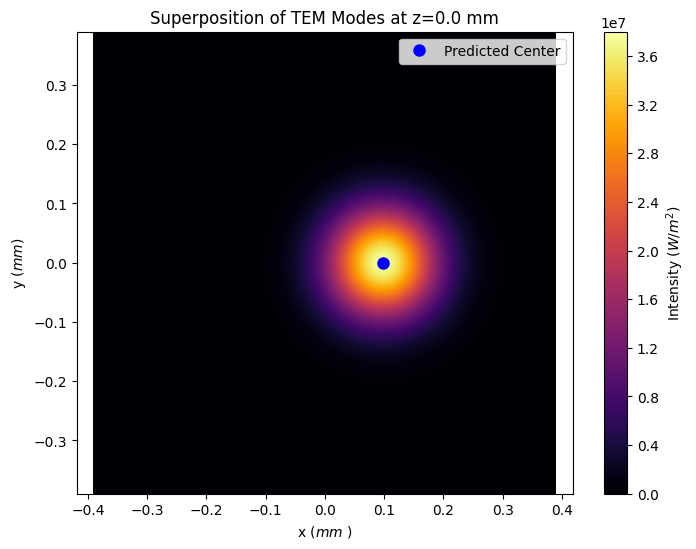

In [38]:
I_super = intensity(X, Y, z, modes_coherent)

# Matplotlib 2D Contour Plot
plt.figure(figsize=(8, 6))
plt.contourf(X*1e3, Y*1e3, I_super, levels=100, cmap='inferno') # Convert to mm for better visualization
plt.colorbar(label='Intensity ($W/m^2$)')

# place a marker at the predicted center
plt.plot(center_pred*1e3, 0, 'bo', label='Predicted Center', markersize=8) # Convert to mm
plt.legend()
plt.title(f'Superposition of TEM Modes at z={z*1e3:.1f} mm')
plt.xlabel('x ($mm$ )')
plt.ylabel('y ($mm$)')
plt.axis('equal')
plt.show()

In [39]:
# 3D Surface Plot with Plotly
fig = go.Figure(data=[go.Surface(z=I_super, x=X*1e3, y=Y*1e3, colorscale='Inferno')])

# set colorbar title
fig.update_traces(colorbar_title='Intensity (W/m²)')

fig.update_layout(title=f'Superposition of TEM Modes at z={z*1e3:.1f} mm)',
                  scene = dict(
                      xaxis_title='X (mm)',
                      yaxis_title='Y (mm)',
                      zaxis_title='Intensity (W/m²)',
                      aspectratio=dict(x=1, y=1, z=0.5)),
                  width=800, height=800,
                  )  
fig.show()

1.0000000000000009


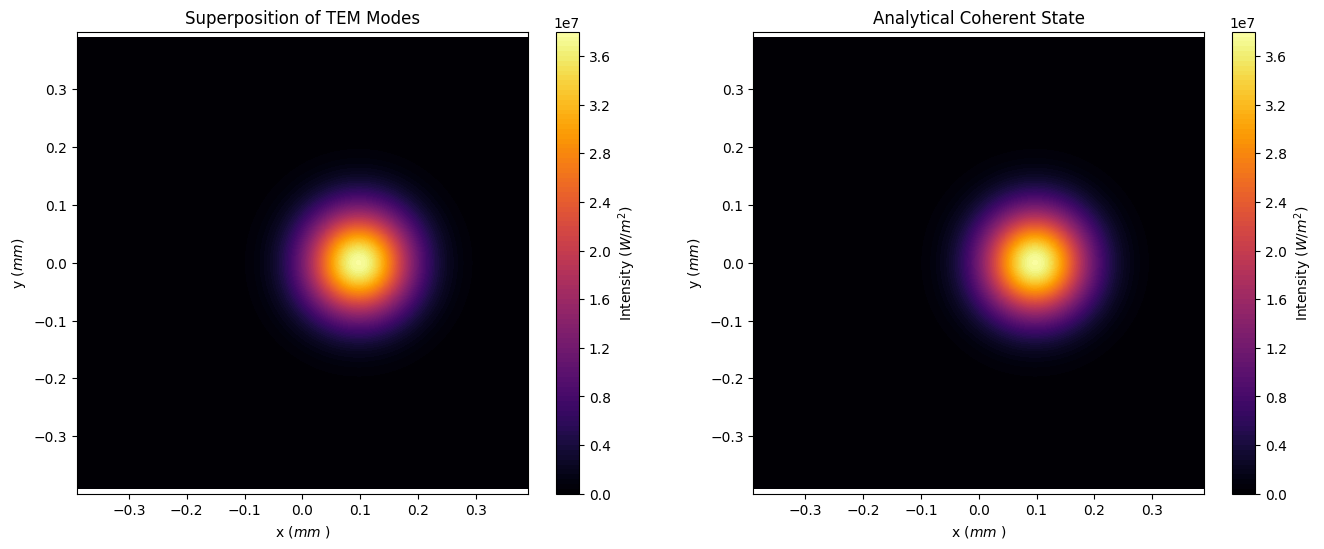

In [40]:
def E_coherent_analytical(x, y, z, alpha):
    A0 = np.sqrt(2.0 / np.pi) / w(z)
    
    prefactor = np.exp((alpha**2 - np.abs(alpha)**2) / 2.0)
    
    x_0 = np.real(alpha) * w(z)

    envelope = np.exp(-((x - x_0)**2 + y**2) / (w(z)**2))

    real = A0 * prefactor * envelope


    radial_phase = -k *(x**2 + y**2)/(2*R(z))
    longitudal_phase = -k*z

    phase = radial_phase + longitudal_phase
    
    return real * np.exp(1j * phase) # Complex electric field


I_analytical = np.abs(E_coherent_analytical(X, Y, z, alpha))**2

print(np.max(I_analytical) / np.max(I_super))


#plot comparison
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.contourf(X*1e3, Y*1e3, I_super, levels=100, cmap='inferno')
plt.colorbar(label='Intensity ($W/m^2$)')
plt.title('Superposition of TEM Modes')
plt.xlabel('x ($mm$ )')
plt.ylabel('y ($mm$)')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.contourf(X*1e3, Y*1e3, I_analytical, levels=100, cmap='inferno')
plt.colorbar(label='Intensity ($W/m^2$)')
plt.title('Analytical Coherent State')
plt.xlabel('x ($mm$ )')
plt.ylabel('y ($mm$)')
plt.axis('equal')
plt.show()

In [41]:
# mse between the two
mse = np.mean((I_super - I_analytical)**2)
mse

np.float64(1.2054476690184676e-17)